In [44]:
import pandas as pd
import pydeck as pdk
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import QuantileRegressor
from geopy.distance import geodesic
import itertools
from itertools import combinations

In [ ]:
asset_impact = pd.read_parquet('/Users/user/Documents/GitHub/Thesis_2425/Data/agg_asset_results.parquet', engine='pyarrow')
firm_impact = pd.read_parquet('/Users/user/Documents/GitHub/Thesis_2425/Data/agg_firm_results.parquet', engine='pyarrow')
ownership = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="ownership")
supply_chain = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="supply chain")
assets = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="assets")
firms = pd.read_excel('/Users/user/Documents/GitHub/Thesis_2425/Data/coal_supply_chain_india_updated2.xlsx', sheet_name="firms")
# === Step 1: Calculate VaR & ES ===
asset_risk = asset_impact.groupby("asset")["impact"].agg([
    ("VaR_95_asset", lambda x: np.percentile(x, 5)),
    ("VaR_99_asset", lambda x: np.percentile(x, 1)),
    ("ES_95_asset", lambda x: x[x <= np.percentile(x, 5)].mean()),
    ("ES_99_asset", lambda x: x[x <= np.percentile(x, 1)].mean()),
]).reset_index()
firm_risk = firm_impact.groupby("firm")["impact"].agg([
    ("VaR_95_firm", lambda x: np.percentile(x, 5)),
    ("VaR_99_firm", lambda x: np.percentile(x, 1)),
    ("ES_95_firm", lambda x: x[x <= np.percentile(x, 5)].mean()),
    ("ES_99_firm", lambda x: x[x <= np.percentile(x, 1)].mean()),
]).reset_index()

## Portfolio Level Analysis

In [46]:
# Step 1: Get firm names from firm_result
firm_names = firm_impact["firm"].unique()
# Step 2: Get firm_ids that match these names using firms
firm_ids = firms[firms["name"].isin(firm_names)]["firm_id"].unique()
# Step 3: Get asset_ids owned by those firm_ids using ownership
ownership_filtered = ownership[ownership["firm_id"].isin(firm_ids)]
asset_ids = ownership_filtered["asset_id"].unique()
# Step 4: Get asset names corresponding to those asset_ids using assets
asset_names = assets[assets["asset_id"].isin(asset_ids)]["name"].unique()
# Step 5: Filter asset_result to keep only those assets
filtered_asset_result = asset_impact[asset_impact["asset"].isin(asset_names)]

filtered_asset_result

,simulation,asset,impact,set-up,exposure
0,4,AKK Coal Mine,-0.128974,Basin-level dependence,1.255819e+08
1,4,ARS Metals Gummidipoondi captive power station,0.000000,Basin-level dependence,6.941087e+07
2,4,ASP Coal Mine,0.000000,Basin-level dependence,9.647503e+06
3,4,Adani Godda power station,0.000000,Basin-level dependence,1.993299e+09
4,4,Adani Raigarh Thermal Power Plant,0.000000,Basin-level dependence,7.474869e+08
...,...,...,...,...,...
67192,1,Wanakbori Thermal Power Station,0.000000,Basin-level dependence,3.476570e+09
67193,1,Wardha Warora Power Plant,0.000000,Basin-level dependence,6.246978e+08
67195,1,West Bokaro Coal Mine,0.000000,Basin-level dependence,1.561097e+07
67196,1,West Jhagrakhand Coal Mine,0.000000,Basin-level dependence,2.816789e+06


In [47]:
def compute_asset_var_with_geo(filtered_asset_result, assets, quantile=0.01):
    """
    Computes the Value at Risk (VaR) at a given quantile for each asset 
    and merges it with geographic coordinates.

    Parameters:
    - filtered_asset_result: DataFrame with ['asset', 'impact'].
    - assets: DataFrame with ['name', 'latitude', 'longitude'].
    - quantile: Float (e.g., 0.01 for 99% VaR, 0.05 for 95% VaR).

    Returns:
    - DataFrame with ['asset', 'VaR_<quantile>', 'latitude', 'longitude'].
    """
    # Compute specified quantile (VaR)
    var_per_asset = (
        filtered_asset_result
        .groupby("asset")["impact"]
        .quantile(quantile)
        .reset_index()
        .rename(columns={"impact": f"VaR_{int((1 - quantile) * 100)}"})
    )

    # Prepare asset names for merge
    assets_renamed = assets.rename(columns={"name": "asset"})

    # Merge with geographic info
    var_with_geo = pd.merge(
        var_per_asset,
        assets_renamed[["asset", "latitude", "longitude"]],
        on="asset",
        how="left"
    )

    return var_with_geo

In [48]:
# Compute VaR_99 (1st percentile)
var99_with_geo = compute_asset_var_with_geo(filtered_asset_result, assets, quantile=0.01)

# Compute VaR_95 (5th percentile)
var95_with_geo = compute_asset_var_with_geo(filtered_asset_result, assets, quantile=0.05)

In [49]:
var99_with_geo

,asset,VaR_99,latitude,longitude
0,AKK Coal Mine,-0.128999,23.790500,85.919800
1,ARS Metals Gummidipoondi captive power station,-1.000000,13.423889,80.066111
2,ASP Coal Mine,0.000000,23.741330,86.405159
3,Adani Godda power station,-1.000000,24.814107,87.135465
4,Adani Raigarh Thermal Power Plant,-1.000000,21.743775,83.274093
...,...,...,...,...
558,Wanakbori Thermal Power Station,-1.000000,22.872537,73.358803
559,Wardha Warora Power Plant,0.000000,20.272443,78.978916
560,West Bokaro Coal Mine,-1.000000,23.792747,85.554231
561,West Jhagrakhand Coal Mine,-0.006288,23.197211,82.161616


In [50]:
'''
# Step 6: Aggregate Asset-Level to Portfolio-Level
asset_impact = (
    filtered_asset_result
    .groupby("simulation")
    .apply(lambda df: (df["impact"] * df["exposure"]).sum() / df["exposure"].sum())
    .reset_index(name="asset_impact")  
)
asset_impact
'''

'\n# Step 6: Aggregate Asset-Level to Portfolio-Level\nasset_impact = (\n    filtered_asset_result\n    .groupby("simulation")\n    .apply(lambda df: (df["impact"] * df["exposure"]).sum() / df["exposure"].sum())\n    .reset_index(name="asset_impact")  \n)\nasset_impact\n'

In [51]:
# Calculate portfolio impact per simulation (exposure-weighted average)
firm_impact_cal = (
    firm_impact
    .groupby("simulation")
    .apply(lambda df: (df["impact"] * df["exposure"]).sum() / df["exposure"].sum())
    .reset_index(name="firm_impact")
)
firm_impact_cal

/var/folders/wy/k_hfp9ls0msf61dg9qbm3h040000gn/T/ipykernel_29791/3355247983.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["impact"] * df["exposure"]).sum() / df["exposure"].sum())


,simulation,firm_impact
0,0,-0.000393
1,1,-0.007730
2,2,-0.000865
3,3,-0.002699
4,4,-0.001170
...,...,...
95,95,-0.000335
96,96,-0.393304
97,97,-0.000337
98,98,-0.000333


In [52]:
# Step 1: Aggregate by simulation
agg = firm_impact.groupby("simulation")[["direct_damages", "business_disruption"]].sum().reset_index()

# Compute channel materiality
agg["share_direct"] = agg["direct_damages"] / (agg["direct_damages"] + agg["business_disruption"])
agg["share_disruption"] = agg["business_disruption"] / (agg["direct_damages"] + agg["business_disruption"])

# Take average materiality across simulations
avg_materiality = agg[["share_direct", "share_disruption"]].mean()

print("Materiality of Financial Transmission Channels:")
print(f"Direct Damages: {avg_materiality['share_direct'] * 100:.1f}%")
print(f"Business Disruption: {avg_materiality['share_disruption'] * 100:.1f}%")

Materiality of Financial Transmission Channels:
Direct Damages: 13.8%
Business Disruption: 86.2%


### Calculate tail risks and for CI (bootstrapping)

In [53]:
def compute_impact_statistics(data, n_bootstrap=1000, ci=95, seed=789, m_ratio=0.85):
    data = np.array(data)
    n = len(data)
    m = int(n * m_ratio)

    # Basic stats
    average_impact = np.mean(data)
    median_impact = np.median(data)
    q5 = np.percentile(data, 5)
    q1 = np.percentile(data, 1)
    es95 = data[data <= q5].mean()
    es99 = data[data <= q1].mean()

    def bootstrap_ci(data, stat_func):
        estimates = []
        np.random.seed(seed)
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=m, replace=True)
            estimates.append(stat_func(sample))
        lower = np.percentile(estimates, (100 - ci) / 2)
        upper = np.percentile(estimates, 100 - (100 - ci) / 2)
        return lower, upper

    # Define stat functions
    avg_func = lambda d: np.mean(d)
    mdn_func = lambda d: np.median(d)
    q5_func = lambda d: np.percentile(d, 5)
    q1_func = lambda d: np.percentile(d, 1)
    es95_func = lambda d: d[d <= np.percentile(d, 5)].mean()
    es99_func = lambda d: d[d <= np.percentile(d, 1)].mean()

    # Compute CIs
    avg_ci_low, avg_ci_high = bootstrap_ci(data, avg_func)
    mdn_ci_low, mdn_ci_high = bootstrap_ci(data, mdn_func)
    q5_ci_low, q5_ci_high = bootstrap_ci(data, q5_func)
    q1_ci_low, q1_ci_high = bootstrap_ci(data, q1_func)
    es95_ci_low, es95_ci_high = bootstrap_ci(data, es95_func)
    es99_ci_low, es99_ci_high = bootstrap_ci(data, es99_func)

    # Collect results
    result_df = pd.DataFrame([
        ["Average Impact", average_impact, avg_ci_low, avg_ci_high],
        ["Median Impact", median_impact, mdn_ci_low, mdn_ci_high],
        ["VaR (95%)", q5, q5_ci_low, q5_ci_high],
        ["VaR (99%)", q1, q1_ci_low, q1_ci_high],
        ["Expected Shortfall (95%)", es95, es95_ci_low, es95_ci_high],
        ["Expected Shortfall (99%)", es99, es99_ci_low, es99_ci_high],
    ], columns=["Metric", "Value", "CI Lower", "CI Upper"])


    return result_df, q5, q1, es95, es99

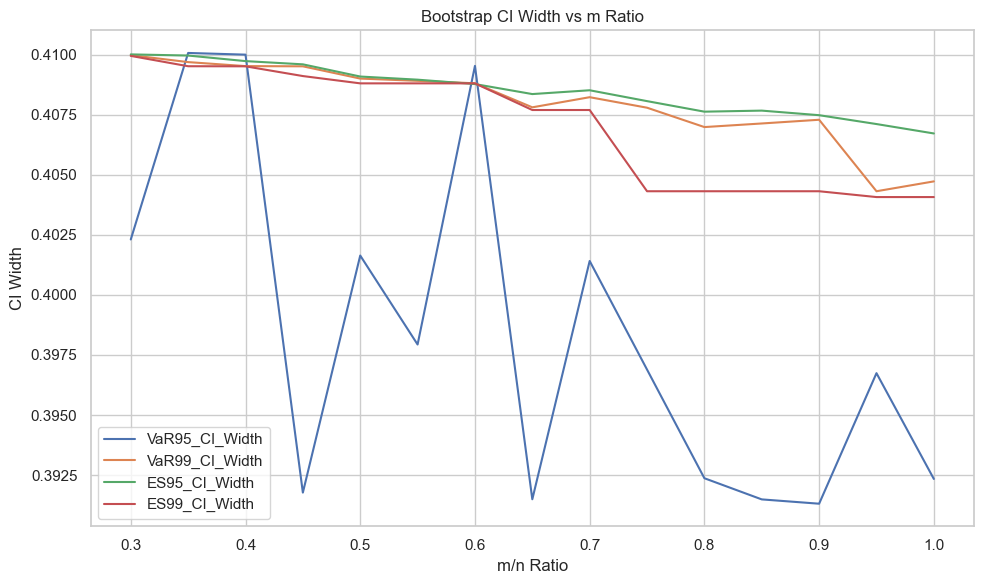

In [54]:
data = firm_impact_cal['firm_impact']
# Store results
ratios = np.linspace(0.3, 1.0, 15)
ci_widths = {
    "m_ratio": [],
    "VaR95_CI_Width": [],
    "VaR99_CI_Width": [],
    "ES95_CI_Width": [],
    "ES99_CI_Width": [],
}

for ratio in ratios:
    result_df, q5, q1, es95, es99 = compute_impact_statistics(data, m_ratio=ratio)
    var95_row = result_df[result_df["Metric"] == "VaR (95%)"]
    var99_row = result_df[result_df["Metric"] == "VaR (99%)"]
    es95_row = result_df[result_df["Metric"] == "Expected Shortfall (95%)"]
    es99_row = result_df[result_df["Metric"] == "Expected Shortfall (99%)"]
    
    ci_widths["m_ratio"].append(ratio)
    ci_widths["VaR95_CI_Width"].append(var95_row["CI Upper"].values[0] - var95_row["CI Lower"].values[0])
    ci_widths["VaR99_CI_Width"].append(var99_row["CI Upper"].values[0] - var99_row["CI Lower"].values[0])
    ci_widths["ES95_CI_Width"].append(es95_row["CI Upper"].values[0] - es95_row["CI Lower"].values[0])
    ci_widths["ES99_CI_Width"].append(es99_row["CI Upper"].values[0] - es99_row["CI Lower"].values[0])

# Convert to DataFrame for plotting
ci_df = pd.DataFrame(ci_widths)

# Plot
plt.figure(figsize=(10, 6))
for metric in ["VaR95_CI_Width", "VaR99_CI_Width", "ES95_CI_Width", "ES99_CI_Width"]:
    plt.plot(ci_df["m_ratio"], ci_df[metric], label=metric)

plt.xlabel("m/n Ratio")
plt.ylabel("CI Width")
plt.title("Bootstrap CI Width vs m Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
firm_summary, firm_q5, firm_q1, firm_es5, firm_es1 = compute_impact_statistics(firm_impact_cal['firm_impact'], m_ratio=0.85)
firm_summary = firm_summary.round(4)
firm_summary

,Metric,Value,CI Lower,CI Upper
0,Average Impact,-0.0130,-0.0295,-0.0008
1,Median Impact,-0.0004,-0.0005,-0.0003
2,VaR (95%),-0.0043,-0.3933,-0.0018
3,VaR (99%),-0.4114,-0.4118,-0.0046
4,Expected Shortfall (95%),-0.2463,-0.4080,-0.0041
5,Expected Shortfall (99%),-0.4118,-0.4118,-0.0075


In [56]:
# Generate all pairwise combinations of metrics
metrics = firm_summary["Metric"].tolist()
pairs = list(combinations(metrics, 2))

# Calculate underestimation ranges for all pairs
results = []
for metric1, metric2 in pairs:
    ci1_low = firm_summary.loc[firm_summary["Metric"] == metric1, "CI Lower"].values[0]
    ci1_high = firm_summary.loc[firm_summary["Metric"] == metric1, "CI Upper"].values[0]
    ci2_low = firm_summary.loc[firm_summary["Metric"] == metric2, "CI Lower"].values[0]
    ci2_high = firm_summary.loc[firm_summary["Metric"] == metric2, "CI Upper"].values[0]

    # Skip if denominator is zero to avoid division errors
    if ci2_low != 0 and ci2_high != 0:
        under_low = (ci2_low - ci1_low) / ci2_low
        under_high = (ci2_high - ci1_high) / ci2_high
        results.append([f"{metric1} vs {metric2}", under_low, under_high])

# Create DataFrame for results
pairwise_underestimation_df = pd.DataFrame(results, columns=["Comparison", "Underestimation Lower", "Underestimation Upper"])

In [57]:
pairwise_underestimation_df

,Comparison,Underestimation Lower,Underestimation Upper
0,Average Impact vs Median Impact,-58.000000,-1.666667
1,Average Impact vs VaR (95%),0.924994,0.555556
2,Average Impact vs VaR (99%),0.928363,0.826087
3,Average Impact vs Expected Shortfall (95%),0.927696,0.804878
4,Average Impact vs Expected Shortfall (99%),0.928363,0.893333
5,Median Impact vs VaR (95%),0.998729,0.833333
6,Median Impact vs VaR (99%),0.998786,0.934783
7,Median Impact vs Expected Shortfall (95%),0.998775,0.926829
8,Median Impact vs Expected Shortfall (99%),0.998786,0.960000
9,VaR (95%) vs VaR (99%),0.044925,0.608696


In [58]:
'''
# Generate all pairwise combinations of metrics
metrics = firm_summary["Metric"].tolist()
pairs = list(combinations(metrics, 2))

# Calculate both directions of underestimation for all metric pairs
results_bidirectional = []

for metric1, metric2 in pairs:
    ci1_low = firm_summary.loc[firm_summary["Metric"] == metric1, "CI Lower"].values[0]
    ci1_high = firm_summary.loc[firm_summary["Metric"] == metric1, "CI Upper"].values[0]
    ci2_low = firm_summary.loc[firm_summary["Metric"] == metric2, "CI Lower"].values[0]
    ci2_high = firm_summary.loc[firm_summary["Metric"] == metric2, "CI Upper"].values[0]

    # Skip if denominator is zero
    if ci2_low != 0 and ci2_high != 0:
        under_low_1 = (ci2_low - ci1_low) / ci2_low
        under_high_1 = (ci2_high - ci1_high) / ci2_high
        results_bidirectional.append([f"{metric1} vs {metric2}", under_low_1, under_high_1])

    if ci1_low != 0 and ci1_high != 0:
        under_low_2 = (ci1_low - ci2_low) / ci1_low
        under_high_2 = (ci1_high - ci2_high) / ci1_high
        results_bidirectional.append([f"{metric2} vs {metric1}", under_low_2, under_high_2])

# Create DataFrame for results
bidirectional_df = pd.DataFrame(results_bidirectional, columns=["Comparison", "Underestimation Lower", "Underestimation Upper"])
'''

'\n# Generate all pairwise combinations of metrics\nmetrics = firm_summary["Metric"].tolist()\npairs = list(combinations(metrics, 2))\n\n# Calculate both directions of underestimation for all metric pairs\nresults_bidirectional = []\n\nfor metric1, metric2 in pairs:\n    ci1_low = firm_summary.loc[firm_summary["Metric"] == metric1, "CI Lower"].values[0]\n    ci1_high = firm_summary.loc[firm_summary["Metric"] == metric1, "CI Upper"].values[0]\n    ci2_low = firm_summary.loc[firm_summary["Metric"] == metric2, "CI Lower"].values[0]\n    ci2_high = firm_summary.loc[firm_summary["Metric"] == metric2, "CI Upper"].values[0]\n\n    # Skip if denominator is zero\n    if ci2_low != 0 and ci2_high != 0:\n        under_low_1 = (ci2_low - ci1_low) / ci2_low\n        under_high_1 = (ci2_high - ci1_high) / ci2_high\n        results_bidirectional.append([f"{metric1} vs {metric2}", under_low_1, under_high_1])\n\n    if ci1_low != 0 and ci1_high != 0:\n        under_low_2 = (ci1_low - ci2_low) / ci1_low

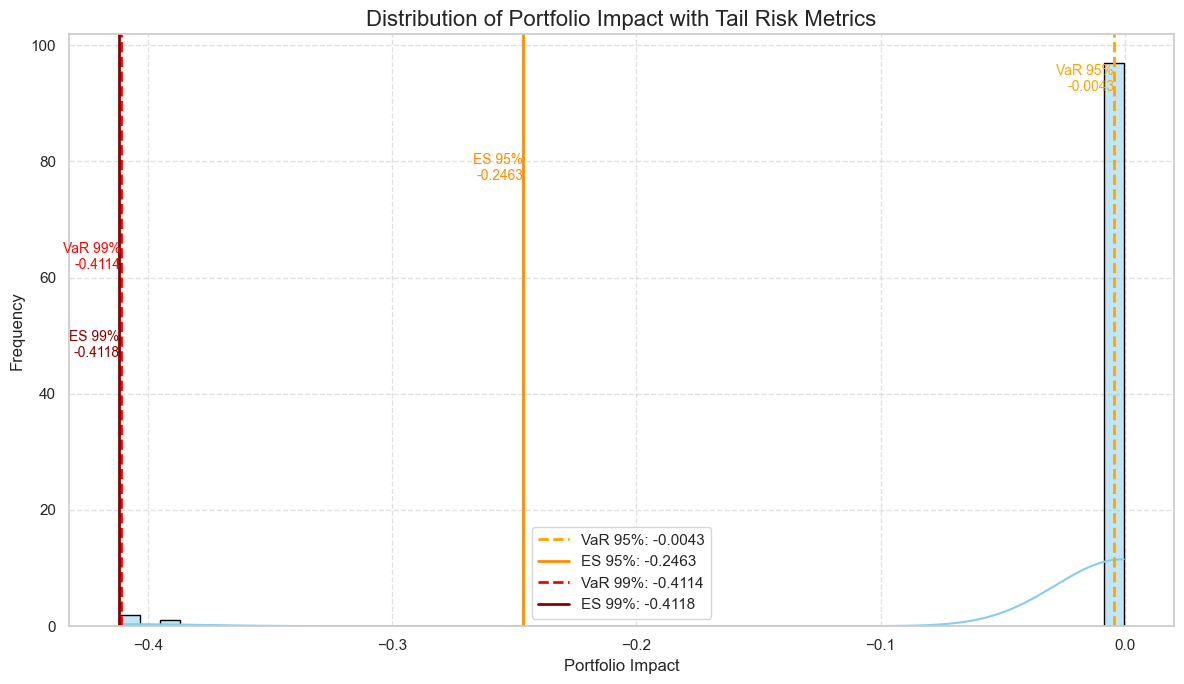

In [59]:
# Set seaborn style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(12, 7))
sns.histplot(firm_impact_cal["firm_impact"], bins=50, kde=True, color='skyblue', edgecolor='black')

# Plot risk metrics as vertical lines
plt.axvline(firm_q5, color='orange', linestyle='--', linewidth=2, label=f'VaR 95%: {firm_q5:.4f}')
plt.axvline(firm_es5, color='darkorange', linestyle='-', linewidth=2, label=f'ES 95%: {firm_es5:.4f}')
plt.axvline(firm_q1, color='red', linestyle='--', linewidth=2, label=f'VaR 99%: {firm_q1:.4f}')
plt.axvline(firm_es1, color='darkred', linestyle='-', linewidth=2, label=f'ES 99%: {firm_es1:.4f}')

# Add text annotations
ylim = plt.ylim()
plt.text(firm_q5, ylim[1]*0.95, f'VaR 95%\n{firm_q5:.4f}', color='orange', ha='right', va='top', fontsize=10)
plt.text(firm_es5, ylim[1]*0.8, f'ES 95%\n{firm_es5:.4f}', color='darkorange', ha='right', va='top', fontsize=10)
plt.text(firm_q1, ylim[1]*0.65, f'VaR 99%\n{firm_q1:.4f}', color='red', ha='right', va='top', fontsize=10)
plt.text(firm_es1, ylim[1]*0.5, f'ES 99%\n{firm_es1:.4f}', color='darkred', ha='right', va='top', fontsize=10)

# Titles and labels
plt.title("Distribution of Portfolio Impact with Tail Risk Metrics", fontsize=16)
plt.xlabel("Portfolio Impact", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Legend and grid
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

# Layout and show
plt.tight_layout()
plt.show()


## Asset & Firm Level Analysis

In [60]:
#asset_level descriptive analysis
cols = ["VaR_95_asset", "VaR_99_asset","ES_95_asset","ES_99_asset"]
summary_stats = asset_risk[cols].agg(["mean", "std", "median", "min", "max"]).T
summary_stats.index.name = "metric"
print(summary_stats)

                  mean       std    median  min       max
metric                                                   
VaR_95_asset -0.029872  0.161830  0.000000 -1.0  0.152215
VaR_99_asset -0.263445  0.432912 -0.001293 -1.0  0.000000
ES_95_asset  -0.093472  0.239576 -0.000127 -1.0  0.000000
ES_99_asset  -0.283485  0.432759 -0.007413 -1.0  0.000000


In [61]:
#firm_level descriptive analysis
cols = ["VaR_95_firm", "VaR_99_firm","ES_95_firm","ES_99_firm"]
summary_stats = firm_risk[cols].agg(["mean", "std", "median", "min", "max"]).T
summary_stats.index.name = "metric"
print(summary_stats)

                 mean       std    median       min  max
metric                                                  
VaR_95_firm -0.013946  0.034928 -0.000009 -0.148068  0.0
VaR_99_firm -0.382735  0.484534 -0.011407 -1.000000  0.0
ES_95_firm  -0.211179  0.293383 -0.003242 -0.676459  0.0
ES_99_firm  -0.400802  0.486944 -0.020380 -1.000000  0.0


In [62]:
# Find the asset with VaR_95 > 0 and its impact distribution
abnormal_assets = asset_risk[asset_risk["VaR_95_asset"] > 0]["asset"]

for asset in abnormal_assets:
    impacts = asset_impact[asset_impact["asset"] == asset]["impact"]
    print(f"\n{asset} - VaR_95 computation check:")
    print(impacts.describe())
    print("Sorted impacts:", sorted(impacts.tolist()))


Ravindrakhani-7 Coal Mine - VaR_95 computation check:
count    100.000000
mean       0.136649
std        0.164289
min       -1.000000
25%        0.159043
50%        0.162377
75%        0.165248
max        0.170705
Name: impact, dtype: float64
Sorted impacts: [-1.0, -1.0, -0.01977002525802518, 0.1343963689677805, 0.13620251174022568, 0.1530575443259583, 0.15375537836493014, 0.1540143264747773, 0.1544568652769247, 0.15549509296499542, 0.15625394351260935, 0.1563087366079532, 0.15641494050880467, 0.15674559316317604, 0.15684611481710298, 0.15693838368383028, 0.15740378676526934, 0.15741948059010857, 0.15798459357591388, 0.15804506891818249, 0.15882800136942876, 0.1588504597739402, 0.15898737486650294, 0.15902512122107315, 0.15904189737866004, 0.15904379146096814, 0.1590853259801548, 0.15920627666469156, 0.15955478780939703, 0.159558170099233, 0.15962040423221624, 0.15963772155617661, 0.1597739601907724, 0.15982658862062116, 0.15999353844692799, 0.16008242502381909, 0.1602601981776015, 0.

### Asset-level supply chain network (Figure 3.1)

In [63]:
# Load asset nodes data
nodes = pd.read_csv("/Users/user/Documents/GitHub/Thesis_2425/Data/total_data.csv", delimiter=";")
nodes["latitude"] = nodes["latitude"].astype(str).str.replace(",", ".").astype(float)
nodes["longitude"] = nodes["longitude"].astype(str).str.replace(",", ".").astype(float)
#nodes = nodes.drop_duplicates(subset="name", keep="first")

# color encoding
def classify_color(asset_id):
    if asset_id.startswith("M"):
        return [220, 30, 30, 180]       # Mine - red
    elif asset_id.startswith("L"):
        return [40, 90, 240, 180]       # Plant - blue
    elif asset_id.startswith("T"):
        return [0, 180, 80, 180]        # Terminal - green
    else:
        return [160, 160, 160, 120]     # Default - grey

nodes["color"] = nodes["asset_id"].apply(classify_color)

# Load supply chain data
edges = pd.read_csv("/Users/user/Documents/GitHub/Thesis_2425/Data/suppy_chain_asset_level", delimiter=",")

# Merge souce & target's lon & lat
edges = edges.merge(
    nodes[["asset_id", "latitude", "longitude"]],
    left_on="supplier",
    right_on="asset_id"
).rename(columns={"latitude": "source_lat", "longitude": "source_lon"})

edges = edges.merge(
    nodes[["asset_id", "latitude", "longitude"]],
    left_on="client",
    right_on="asset_id"
).rename(columns={"latitude": "target_lat", "longitude": "target_lon"})

# Remove self-loops(source == target)
edges = edges[~(
    (edges["source_lat"] == edges["target_lat"]) & 
    (edges["source_lon"] == edges["target_lon"])
)]

# Build ArcLaye
arc_layer = pdk.Layer(
    "ArcLayer",
    data=edges,
    get_source_position=["source_lon", "source_lat"],
    get_target_position=["target_lon", "target_lat"],
    get_source_color=[255, 100, 0, 80],    #organge
    get_target_color=[255, 255, 180, 80],  #yellow
    get_width=1,
    auto_highlight=True,
    pickable=True
)

# Construct node layer (with color encoding)
node_layer = pdk.Layer(
    "ScatterplotLayer",
    data=nodes,
    get_position=["longitude", "latitude"],
    get_fill_color="color",   
    get_radius=10000,
    pickable=True,
)

# Build Deck map
view_state = pdk.ViewState(latitude=22.5, longitude=82.0, zoom=4, bearing=0, pitch=0)

deck = pdk.Deck(
    layers=[node_layer, arc_layer],
    initial_view_state=view_state,
    tooltip={"text": "From: {supplier}\nTo: {client}\nProduct: {product}"}
)

# Output as HTML as local path
deck.to_html("/Users/user/Desktop/supply_chain_arc_map1.html", notebook_display=False)

# Print the number of valid linkages
print("Number of edges (arcs):", len(edges))

Number of edges (arcs): 552


### Asset-level Impact (VaR_99) with Log-like Scaling (Figure 4.4)

In [64]:
# Merge asset_risk with nodes
asset_risk["asset"] = asset_risk["asset"].str.strip()
nodes["name"] = nodes["name"].str.strip()

# Merge VaR_95, VaR_99, ES_95, ES_99
nodes = nodes.merge(
    asset_risk[["asset", "VaR_95_asset", "VaR_99_asset", "ES_95_asset", "ES_99_asset"]],
    left_on="name",
    right_on="asset",
    how="left"
)

# Fill NA with 0
for col in ["VaR_95_asset", "VaR_99_asset", "ES_95_asset", "ES_99_asset"]:
    nodes[col] = nodes[col].fillna(0)

# Set radius based on impact level 
nodes["impact_radius"] = nodes["VaR_99_asset"].apply(
    lambda v: 5000 if v >= 0 else 5000 + np.log1p(-v * 1000) * 5000
)

impact_layer = pdk.Layer(
    "ScatterplotLayer",
    data=nodes,
    get_position=["longitude", "latitude"],
    get_radius="impact_radius",
    get_fill_color=[180, 100, 255, 80],  # purple
    stroked=False,
    pickable=True
)

view_state = pdk.ViewState(latitude=22.5, longitude=82.0, zoom=4)

# Create Deck map
deck = pdk.Deck(
    layers=[node_layer, impact_layer],
    initial_view_state=view_state,
    tooltip={
        "text": "Asset: {name}\nVaR_99: {VaR_99_str}\nLat: {lat_str}, Lon: {lon_str}"
    }
)

deck.to_html("/Users/user/Desktop/asset_impact.html", notebook_display=False)

In [65]:
nodes

,asset_id,name,latitude,longitude,country,production,firm,color,asset,VaR_95_asset,VaR_99_asset,ES_95_asset,ES_99_asset,impact_radius
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,"0,715",Coal India Ltd [100.0%],"[220, 30, 30, 180]",Adasa Coal Mine,0.0,0.000000,0.000000,0.000000,5000.000000
1,M0465,Adriyala Coal Mine,18.664800,79.579000,India,"1,7",The Singareni Collieries Co Ltd [100%],"[220, 30, 30, 180]",Adriyala Coal Mine,0.0,-1.000000,-0.020000,-1.000000,39543.773897
2,M0466,AKK Coal Mine,23.790500,85.919800,India,"5,35",Coal India Ltd [100.0%],"[220, 30, 30, 180]",AKK Coal Mine,0.0,-0.128999,-0.002772,-0.131469,29337.627233
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,"3,32",Coal India Ltd [100.0%],"[220, 30, 30, 180]",Amadand Coal Mine,0.0,-0.003691,-0.000081,-0.004369,12728.358021
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.807800,86.322100,India,"3,14",Coal India Ltd [100.0%],"[220, 30, 30, 180]",Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,0.0,0.000000,0.000000,0.000000,5000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,T01164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement,"[0, 180, 80, 180]",Sikka Port Coal Terminal,0.0,0.000000,0.000000,0.000000,5000.000000
669,T01169,Trombay Coal Terminal,18.991606,72.908227,India,"2,4",Tata Group,"[0, 180, 80, 180]",Trombay Coal Terminal,0.0,-1.000000,-0.030195,-1.000000,39543.773897
670,T01165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group,"[0, 180, 80, 180]",Tuna Tekra Port Coal Terminal,0.0,-1.000000,-0.030612,-1.000000,39543.773897
671,T01176,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust,"[0, 180, 80, 180]",Tuticorin Port Coal Terminal,0.0,0.000000,0.000000,0.000000,5000.000000


### Violin Plot on Asset Level (Figure 4.3)

/var/folders/wy/k_hfp9ls0msf61dg9qbm3h040000gn/T/ipykernel_29791/3897690998.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=nodes, x="type", y="VaR_95_asset", palette=palette, saturation=0.6, ax=axes[0, 0])
/var/folders/wy/k_hfp9ls0msf61dg9qbm3h040000gn/T/ipykernel_29791/3897690998.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=nodes, x="type", y="VaR_99_asset", palette=palette, saturation=0.6, ax=axes[0, 1])
/var/folders/wy/k_hfp9ls0msf61dg9qbm3h040000gn/T/ipykernel_29791/3897690998.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same e

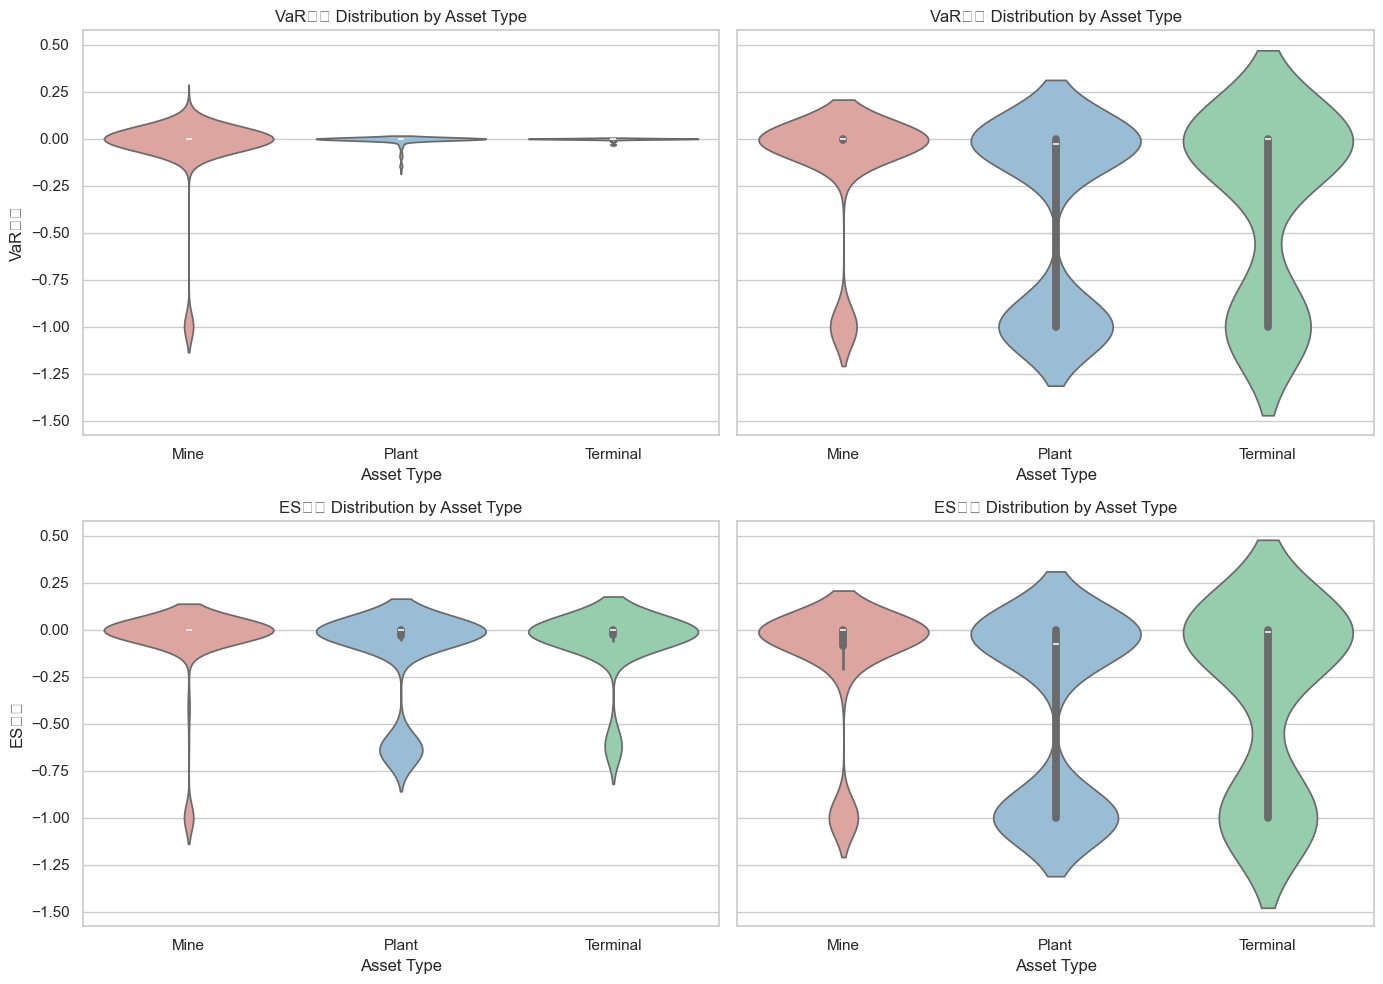

In [66]:
nodes["type"] = nodes["asset_id"].str[0].map({
    "M": "Mine",
    "L": "Plant",
    "T": "Terminal"
})
# Color encoding
palette = {
    "Mine": "#F1948A",      # red
    "Plant": "#85C1E9",     # blue
    "Terminal": "#82E0AA"   # green
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Violin plot: VaR_95
sns.violinplot(data=nodes, x="type", y="VaR_95_asset", palette=palette, saturation=0.6, ax=axes[0, 0])
axes[0, 0].set_title("VaR₉₅ Distribution by Asset Type")
axes[0, 0].set_xlabel("Asset Type")
axes[0, 0].set_ylabel("VaR₉₅")

# Violin plot: VaR_99
sns.violinplot(data=nodes, x="type", y="VaR_99_asset", palette=palette, saturation=0.6, ax=axes[0, 1])
axes[0, 1].set_title("VaR₉₉ Distribution by Asset Type")
axes[0, 1].set_xlabel("Asset Type")
axes[0, 1].set_ylabel("VaR₉₉")

# Violin plot: ES_95
sns.violinplot(data=nodes, x="type", y="ES_95_asset", palette=palette, saturation=0.6, ax=axes[1, 0])
axes[1, 0].set_title("ES₉₅ Distribution by Asset Type")
axes[1, 0].set_xlabel("Asset Type")
axes[1, 0].set_ylabel("ES₉₅")

# Violin plot: ES_99
sns.violinplot(data=nodes, x="type", y="ES_99_asset", palette=palette, saturation=0.6, ax=axes[1, 1])
axes[1, 1].set_title("ES₉₉ Distribution by Asset Type")
axes[1, 1].set_xlabel("Asset Type")
axes[1, 1].set_ylabel("ES₉₉")

plt.tight_layout()
plt.show()

### Firm-level Supply Chain Network and VaR_99 (Figure 3.2 & 4.5)

In [67]:
assets = assets.rename(columns={"name": "asset_name"})
firms = firms.rename(columns={"name": "firm_name"})
asset_impact = asset_impact.merge(assets, left_on="asset", right_on="asset_name", how="left")
asset_impact = asset_impact.merge(ownership, on="asset_id", how="left")
asset_impact = asset_impact.merge(firms, on="firm_id", how="left")

firm_structure = asset_impact.groupby("firm_name").agg({
    "asset": "count",                 
})
firm_structure.columns = [
    "num_assets"
]
firm_structure["num_assets"] = (firm_structure["num_assets"] / 100).astype(int)
firm_structure = firm_structure.reset_index()
firm_risk["firm"] = firm_risk["firm"].str.strip()
firm_structure["firm_name"] = firm_structure["firm_name"].str.strip()
firm_structure = firm_structure.merge(
    firm_risk[["firm", "VaR_99_firm"]],
    left_on="firm_name",
    right_on="firm",
    how="left"
)
firm_structure
# Create data to build firm-level supply chain via Gephi
firm_structure.drop(columns=["firm"])
nodes_gephi = firm_structure.rename(columns={
    "firm_name": "Id",
    "num_assets": "num_assets",
    "VaR_99_firm": "VaR_99_firm"
})
nodes_gephi["Label"] = nodes_gephi["Id"]
nodes_gephi.to_csv("/Users/user/Desktop/gephi_nodes.csv", index=False)